In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_39_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fa675011b70> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(109332)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

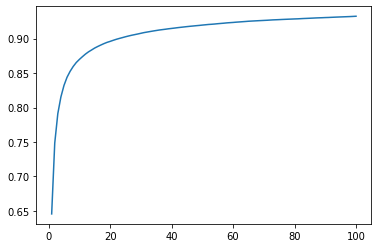

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.6456, 0.7484, 0.7912, 0.8153, 0.8320, 0.8439, 0.8525, 0.8596, 0.8653,
        0.8698, 0.8738, 0.8776, 0.8809, 0.8836, 0.8864, 0.8886, 0.8907, 0.8928,
        0.8946, 0.8960, 0.8975, 0.8990, 0.9003, 0.9014, 0.9027, 0.9038, 0.9049,
        0.9058, 0.9067, 0.9077, 0.9087, 0.9095, 0.9103, 0.9111, 0.9118, 0.9125,
        0.9131, 0.9136, 0.9143, 0.9148, 0.9153, 0.9159, 0.9164, 0.9169, 0.9174,
        0.9179, 0.9183, 0.9188, 0.9192, 0.9197, 0.9201, 0.9205, 0.9208, 0.9212,
        0.9217, 0.9220, 0.9224, 0.9229, 0.9232, 0.9235, 0.9239, 0.9242, 0.9245,
        0.9249, 0.9252, 0.9255, 0.9257, 0.9260, 0.9262, 0.9264, 0.9266, 0.9269,
        0.9272, 0.9274, 0.9276, 0.9278, 0.9280, 0.9282, 0.9284, 0.9286, 0.9287,
        0.9290, 0.9292, 0.9294, 0.9296, 0.9298, 0.9300, 0.9302, 0.9303, 0.9306,
        0.9307, 0.9309, 0.9311, 0.9313, 0.9315, 0.9317, 0.9318, 0.9320, 0.9322,
        0.9325])

In [18]:
percentages.max()

tensor(0.9325)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.67641414, 0.66099868, 0.64792758, 0.63710044, 0.62730553,
       0.61838497, 0.61078572, 0.60388752, 0.59788057, 0.59224473,
       0.58696739, 0.58212474, 0.57753517, 0.57347514, 0.56963441,
       0.56606783, 0.56267943, 0.55954417, 0.55654407, 0.5537176 ,
       0.55110099, 0.54858429, 0.54618039, 0.54389489, 0.54170412,
       0.53957603, 0.53755636, 0.53558036, 0.53369727, 0.531872  ,
       0.53008544, 0.52837916, 0.52671868, 0.5250956 , 0.52354452,
       0.52200547, 0.52056764, 0.5191497 , 0.51776466, 0.51645182,
       0.51513259, 0.51386507, 0.51267546, 0.51147953, 0.51029607,
       0.50913672, 0.5080007 , 0.50687756, 0.50582497, 0.50474374,
       0.50369635, 0.50265597, 0.50168403, 0.50070622, 0.49976277,
       0.4988138 , 0.49788134, 0.49697798, 0.49609753, 0.49521051,
       0.49433689, 0.49347345, 0.49265682, 0.49185058, 0.49103717,
       0.49025897, 0.48947649, 0.48871799, 0.4879439 , 0.48720163,
       0.48645557, 0.4857194 , 0.48503244, 0.48433892, 0.48362

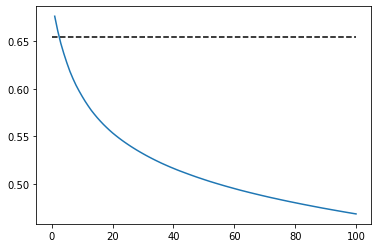

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa64e18e4b0> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(131285)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8708527392009273

In [81]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [82]:
indices

array([[     0,  12093,  36054, ...,  70820, 140830, 139581],
       [     1, 154949, 100594, ...,   4965, 141186,  78598],
       [     2, 113232,   6082, ...,  63781,   3232,  63389],
       ...,
       [169340,  18094, 154295, ...,  94810,  72796, 141281],
       [169341, 146945,   7570, ...,  93054,  79872, 156052],
       [169342,  68071,  40091, ..., 134625,   4353, 157945]])

In [83]:
sum(emb_norm[0] * emb_norm[411])

0.7417054784018546

In [84]:
distances

array([[1.        , 0.95901346, 0.9510875 , ..., 0.84615993, 0.84610903,
        0.8460091 ],
       [0.9999998 , 0.9892719 , 0.91474867, ..., 0.575844  , 0.574418  ,
        0.5738992 ],
       [0.99999964, 0.9225734 , 0.91027015, ..., 0.76821136, 0.76626456,
        0.76605034],
       ...,
       [0.99999994, 0.9198044 , 0.8818623 , ..., 0.691268  , 0.69101614,
        0.6908942 ],
       [1.        , 0.94718724, 0.9137265 , ..., 0.8507452 , 0.85068756,
        0.85004234],
       [0.99999976, 0.9061285 , 0.89423555, ..., 0.66931665, 0.6692642 ,
        0.668807  ]], dtype=float32)

In [85]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [86]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

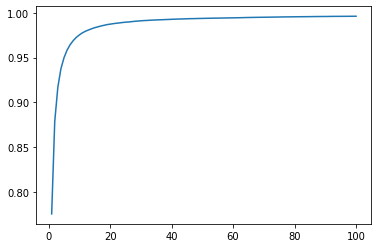

In [87]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [88]:
percentages

tensor([0.7753, 0.8786, 0.9167, 0.9373, 0.9497, 0.9582, 0.9643, 0.9689, 0.9725,
        0.9753, 0.9776, 0.9794, 0.9808, 0.9821, 0.9833, 0.9843, 0.9852, 0.9860,
        0.9868, 0.9873, 0.9878, 0.9883, 0.9887, 0.9891, 0.9895, 0.9897, 0.9901,
        0.9905, 0.9908, 0.9911, 0.9913, 0.9915, 0.9917, 0.9919, 0.9920, 0.9922,
        0.9923, 0.9924, 0.9926, 0.9927, 0.9929, 0.9930, 0.9931, 0.9932, 0.9933,
        0.9934, 0.9935, 0.9936, 0.9937, 0.9937, 0.9938, 0.9939, 0.9939, 0.9940,
        0.9941, 0.9941, 0.9942, 0.9942, 0.9943, 0.9944, 0.9944, 0.9945, 0.9946,
        0.9947, 0.9947, 0.9948, 0.9949, 0.9949, 0.9950, 0.9950, 0.9951, 0.9951,
        0.9952, 0.9952, 0.9953, 0.9954, 0.9954, 0.9954, 0.9955, 0.9955, 0.9956,
        0.9956, 0.9956, 0.9957, 0.9957, 0.9958, 0.9958, 0.9958, 0.9959, 0.9959,
        0.9959, 0.9960, 0.9960, 0.9960, 0.9960, 0.9960, 0.9961, 0.9961, 0.9961,
        0.9961])

### Percentage of same class neighbors by neighborhood size

In [89]:
ind_labels = label_transform(indices)

In [90]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [91]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [92]:
perc_same_class = n_same_class / n_total

In [93]:
perc_same_class

array([0.68205358, 0.66987121, 0.65886199, 0.649178  , 0.64058627,
       0.6331548 , 0.62639225, 0.62008468, 0.61440193, 0.60922979,
       0.60455675, 0.60027134, 0.59620279, 0.59239236, 0.58879828,
       0.58545674, 0.58228218, 0.5793288 , 0.57665212, 0.5740813 ,
       0.57157255, 0.5692532 , 0.56696147, 0.56482233, 0.56273221,
       0.56080558, 0.55892238, 0.55708132, 0.55538657, 0.55372804,
       0.55215022, 0.55059923, 0.54912345, 0.54765615, 0.54625009,
       0.54492394, 0.54355505, 0.54226815, 0.54097926, 0.53978833,
       0.53861804, 0.53750067, 0.53635727, 0.53525497, 0.53416701,
       0.53314947, 0.53211492, 0.5311322 , 0.53013043, 0.52914452,
       0.52822425, 0.52729326, 0.52638839, 0.52548444, 0.52463247,
       0.52379501, 0.52296538, 0.52214695, 0.52134345, 0.52056526,
       0.51977599, 0.51903419, 0.51830712, 0.51757518, 0.51685986,
       0.51615602, 0.51547319, 0.51477023, 0.5140897 , 0.51341757,
       0.51273509, 0.51210085, 0.5114522 , 0.51081174, 0.51018

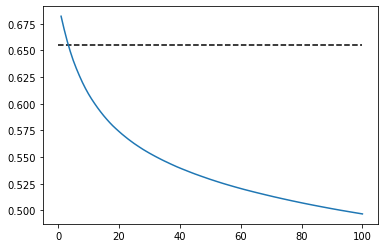

In [94]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

### TODO: Percentage of same class neighbors by angular section

In [101]:
(distances > 0.9) * indices

array([[     0,  12093,  36054, ...,      0,      0,      0],
       [     1, 154949, 100594, ...,      0,      0,      0],
       [     2, 113232,   6082, ...,      0,      0,      0],
       ...,
       [169340,  18094,      0, ...,      0,      0,      0],
       [169341, 146945,   7570, ...,      0,      0,      0],
       [169342,  68071,      0, ...,      0,      0,      0]])

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa64c0cc300> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(99749)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

5.324377545242896

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[ 61100, 127259, 123288, ...,   4476,  48850, 117193],
       [141692,      1, 129182, ...,  86560,  33594, 120715],
       [ 14632, 168209,  87117, ..., 113772,  39837, 104462],
       ...,
       [103381, 141153,  43354, ..., 141281,   8476,  81417],
       [ 61100, 127259,  67166, ..., 164591,  68037,  15006],
       [ 27824,  64718, 158981, ..., 115102,  69952, 106833]])

In [61]:
sum(embeddings[0] * embeddings[411])

9.648755090485793

In [62]:
distances

array([[30.716135 , 26.25008  , 26.231157 , ..., 16.286335 , 16.209057 ,
        16.17083  ],
       [ 7.6519833,  6.5468807,  6.468119 , ...,  4.4157276,  4.4096384,
         4.401203 ],
       [10.181744 , 10.017241 ,  9.915219 , ...,  7.211259 ,  7.2015452,
         7.1865196],
       ...,
       [11.687528 , 10.91846  , 10.805123 , ...,  7.9384685,  7.9332123,
         7.9257665],
       [15.018407 , 13.43196  , 13.323221 , ...,  9.868516 ,  9.865654 ,
         9.834744 ],
       [ 8.28519  ,  7.6366615,  7.311316 , ...,  3.7742302,  3.7720056,
         3.7568204]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

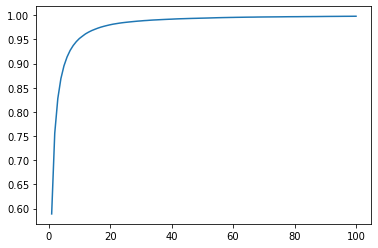

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.5890, 0.7559, 0.8279, 0.8690, 0.8955, 0.9137, 0.9273, 0.9375, 0.9455,
        0.9519, 0.9569, 0.9616, 0.9652, 0.9684, 0.9710, 0.9734, 0.9755, 0.9773,
        0.9789, 0.9804, 0.9817, 0.9828, 0.9838, 0.9847, 0.9854, 0.9861, 0.9867,
        0.9874, 0.9880, 0.9884, 0.9890, 0.9894, 0.9899, 0.9903, 0.9906, 0.9909,
        0.9912, 0.9915, 0.9918, 0.9921, 0.9924, 0.9927, 0.9929, 0.9931, 0.9933,
        0.9935, 0.9937, 0.9938, 0.9940, 0.9942, 0.9943, 0.9945, 0.9947, 0.9949,
        0.9951, 0.9952, 0.9953, 0.9955, 0.9956, 0.9957, 0.9958, 0.9959, 0.9960,
        0.9961, 0.9962, 0.9963, 0.9963, 0.9965, 0.9965, 0.9966, 0.9966, 0.9967,
        0.9968, 0.9968, 0.9969, 0.9969, 0.9970, 0.9971, 0.9971, 0.9972, 0.9972,
        0.9972, 0.9973, 0.9973, 0.9974, 0.9974, 0.9975, 0.9975, 0.9976, 0.9977,
        0.9977, 0.9978, 0.9978, 0.9978, 0.9979, 0.9979, 0.9980, 0.9980, 0.9981,
        0.9981])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.63009986, 0.62113875, 0.61290202, 0.60557567, 0.5993209 ,
       0.5937417 , 0.58828953, 0.58384019, 0.57963423, 0.57570847,
       0.57218298, 0.56874312, 0.56553131, 0.56245566, 0.55962435,
       0.55691887, 0.55449382, 0.55216139, 0.54994519, 0.54783014,
       0.5457779 , 0.54387518, 0.54201904, 0.54022826, 0.53850918,
       0.53687078, 0.53532333, 0.53384635, 0.53234783, 0.53098878,
       0.52970751, 0.52840481, 0.5271732 , 0.52597322, 0.52479001,
       0.52363809, 0.52249991, 0.52139585, 0.52033856, 0.5193204 ,
       0.51832628, 0.51738413, 0.51644282, 0.51553209, 0.51463125,
       0.51379243, 0.51292863, 0.51210954, 0.51128485, 0.510487  ,
       0.50969346, 0.50890364, 0.50816836, 0.50744282, 0.50670457,
       0.50598426, 0.50529803, 0.5045874 , 0.50389877, 0.50324627,
       0.50258671, 0.50196423, 0.50131953, 0.50070142, 0.50009371,
       0.4995071 , 0.49891843, 0.49835376, 0.49780272, 0.49722651,
       0.4966642 , 0.49612981, 0.49558297, 0.49502744, 0.49449

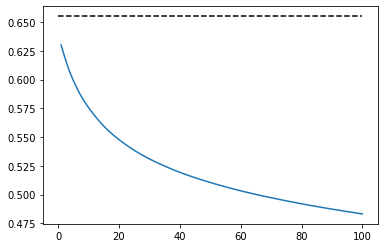

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

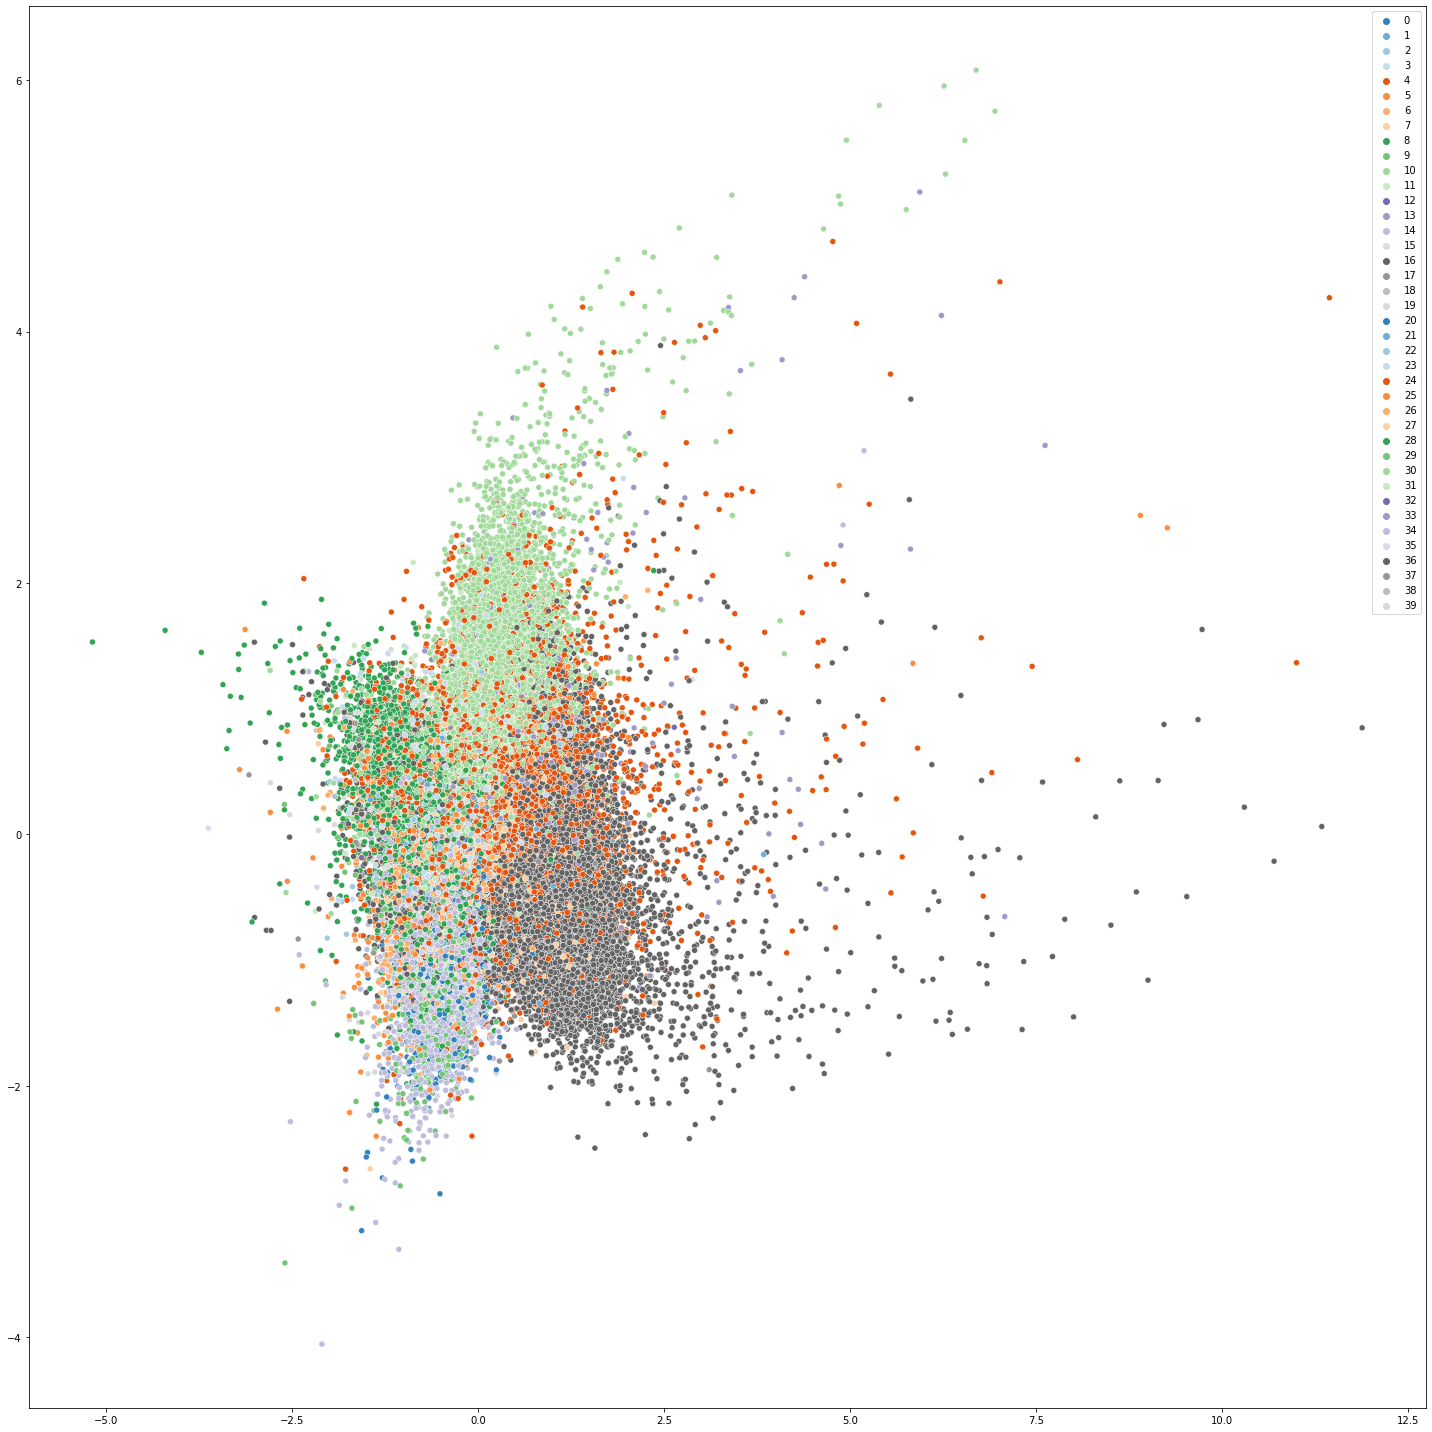

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

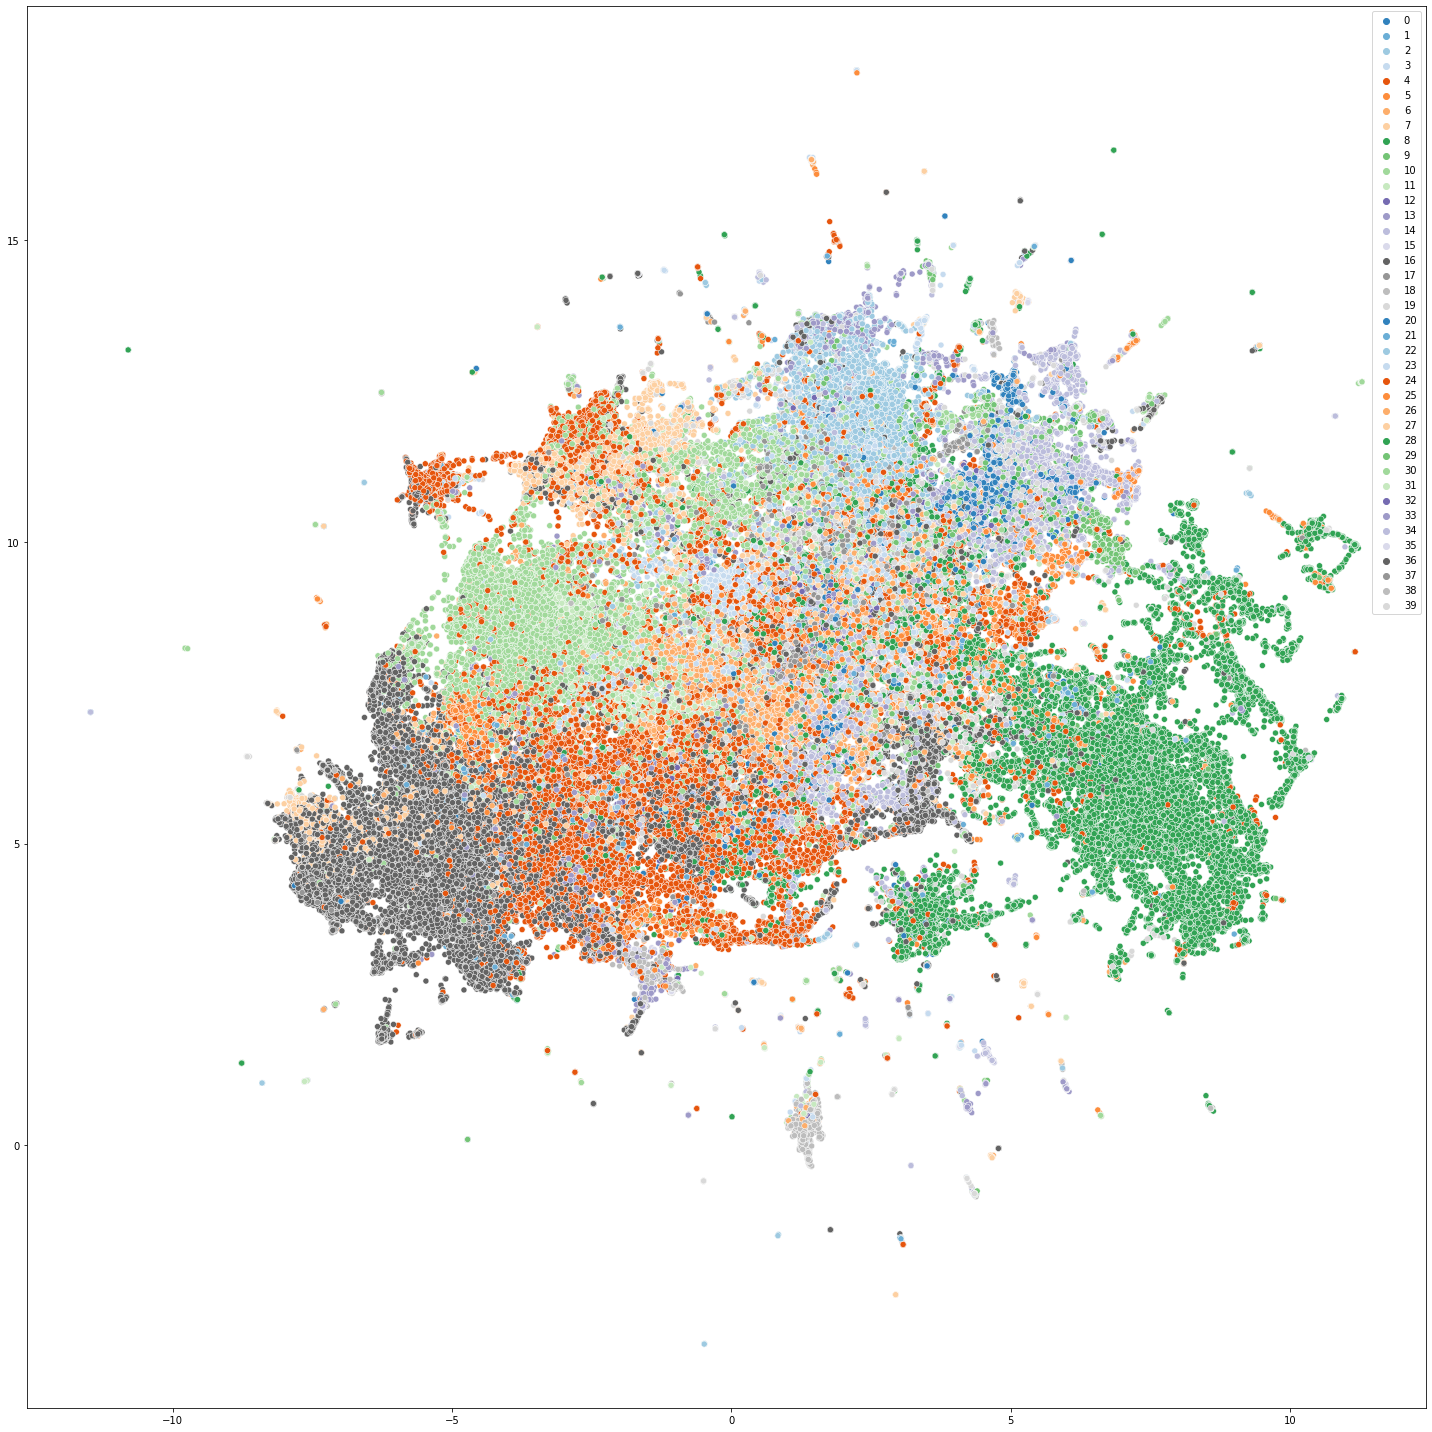

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

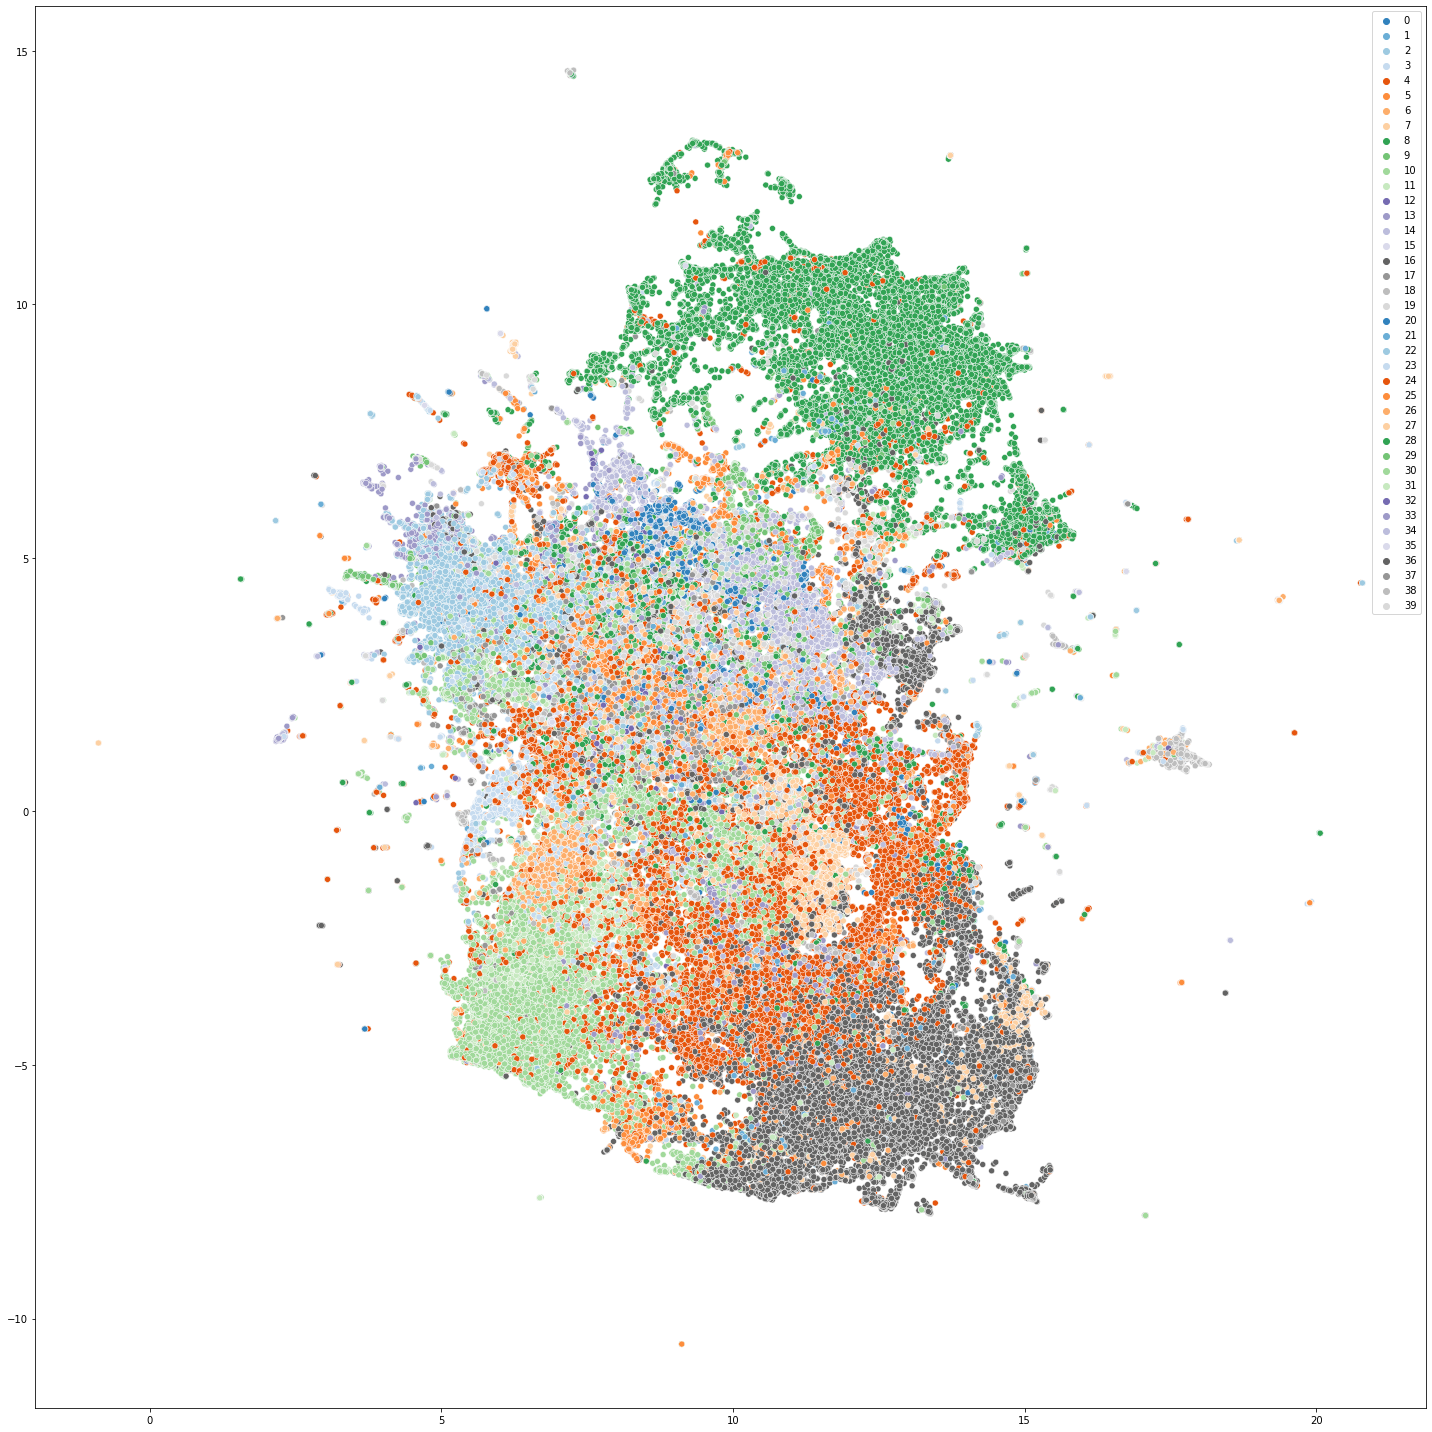

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()